# Modeling Multiclasse (backup)
📒 `_bkp-4.0-rc-modeling_multiclasses.ipynb`

Será considerado a Classificação Binária no notebook > 📒 `3.0-rc-modeling.ipynb`

In [12]:
# === Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load

# Pipeline
from sklearn.pipeline import Pipeline
# Cross-Validation
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

# Modelos
from sklearn.linear_model import LogisticRegression # Regressão Logística   
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier # XGBoost

# Métricas de Avaliação
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Carrega Funções Auxiliares
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src._utils import obter_medidas


## 2) Treinamento de Modelos - Classificação Multiclasses

- **Baseline:** LogisticRegression()
- **Ensemble:**  RandomForestClassifier(), XGBClassifier()


####  Carregar artefatos e dados de treino e teste

In [13]:
# Carrega artefatos da etapa de PREPROCESSING
spec = load("../models/artifacts/preprocessing_spec.joblib")
preprocessor   = spec["preprocessor"]          
RANDOM_SEED    = spec["random_seed"]
target_name    = spec["target_name"]

# Carrega os dados tratados
X_train = pd.read_csv("../data/interim/X_train.csv")
X_test  = pd.read_csv("../data/interim/X_test.csv")
y_train = pd.read_csv("../data/interim/y_train.csv")[target_name]
y_test  = pd.read_csv("../data/interim/y_test.csv")[target_name]

# Visualiza o preprocessor
preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


### 2.1.) Baseline - LogisticRegression() 


=== CV (5-fold) - Logistic Regression (Multiclasse) ===
      metric     mean      std
    f1_macro 0.132591 0.009392
recall_macro 0.558662 0.039774


c:\Users\reyna\_python_projects\personal\portfolio-projects\predictive-maintenance-failure-classifier\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



Probabilidades por classe (amostras do conjunto de teste):
   Desgaste da Ferramenta(FDF)  Dissipacao de Calor(FDC)  Falha Aleatoria(FA)  \
0                     0.200422                  0.028454             0.325447   
1                     0.017158                  0.050149             0.433602   
2                     0.065596                  0.026488             0.239050   
3                     0.048534                  0.033871             0.299854   
4                     0.039593                  0.198390             0.356457   

   Falha de Potencia(FP)  Sem falhas  Tensao Excessiva(FTE)  
0               0.026766    0.362004               0.056907  
1               0.061907    0.435192               0.001993  
2               0.311744    0.337555               0.019567  
3               0.084151    0.532295               0.001294  
4               0.038164    0.344656               0.022741  

Baseline (Multiclasse) - Logistic Regression

=== Classification Report (por cla

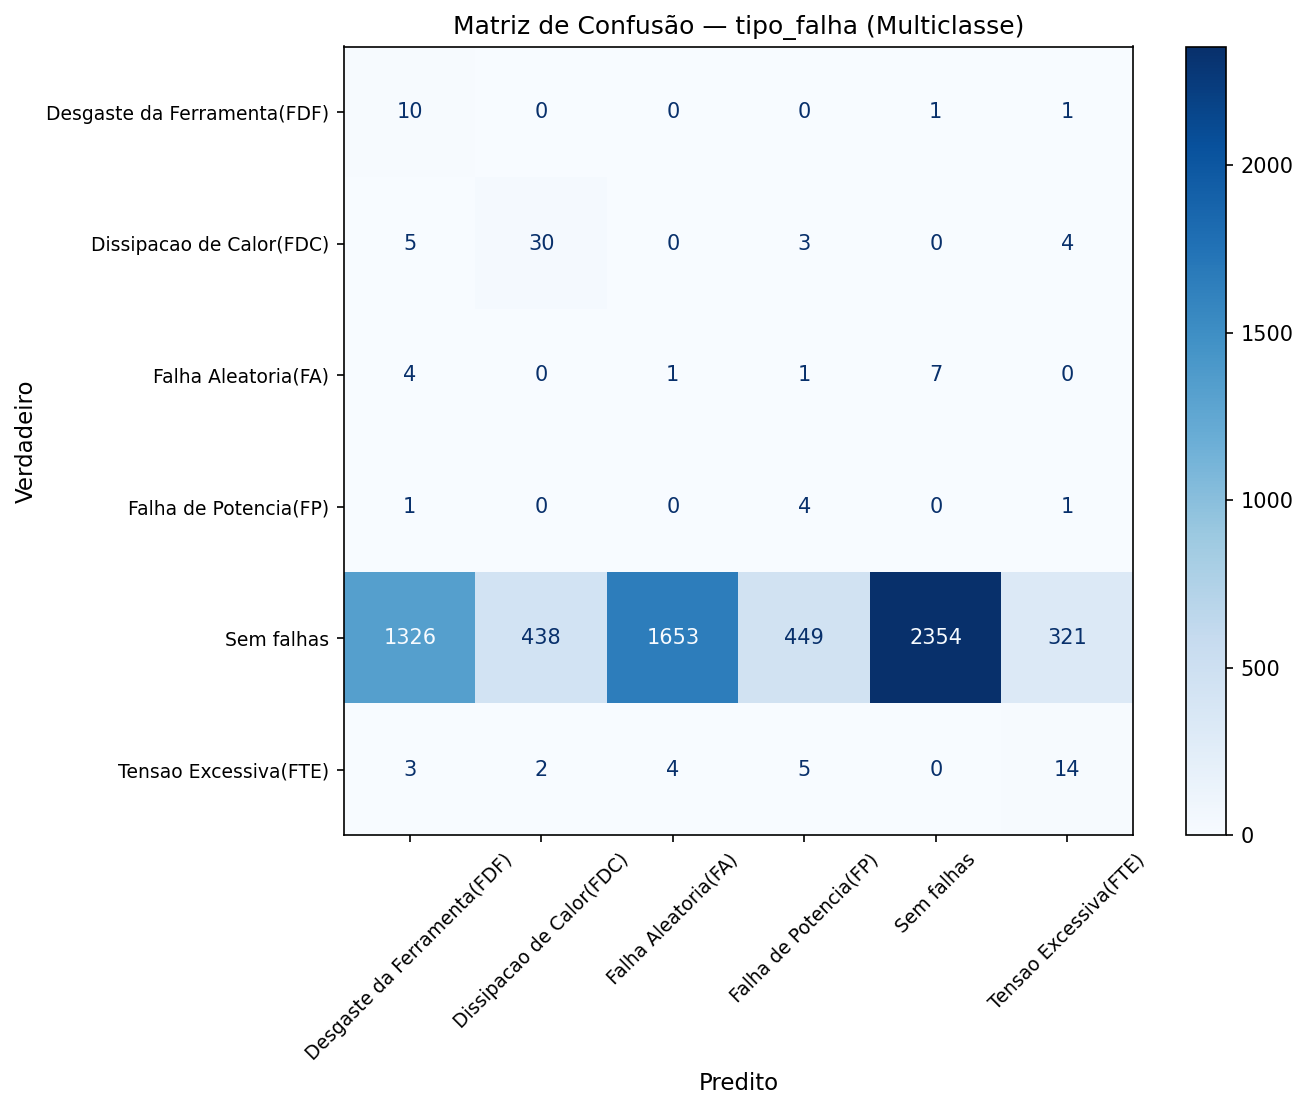

In [16]:
# === Definição do Pipeline Baseline: Logistic Regression (multiclasse) ===
# - multi_class='multinomial' com solver 'lbfgs' para 5 classes
# - class_weight='balanced' - para compensar o desbalanceamento entre as 5 classes
lr_pipe_baseline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        class_weight='balanced',
        random_state=RANDOM_SEED
    ))
])

# === Cross-Validation (5 folds) ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Conjunto de métricas apropriadas para MULTICLASSE

scores = cross_validate(
    lr_pipe_baseline,
    X_train,
    y_train,
    cv=cv,
    scoring=["recall_macro","f1_macro"],
    return_train_score=True,
    n_jobs=-1
)

# Resumo dos scores (média ± std)
def _resume_cv(scores_dict, prefix="test_"):
    rows = []
    for k, v in scores_dict.items():
        if k.startswith(prefix):
            metric = k.replace(prefix, "")
            mean = np.mean(v)
            std  = np.std(v)
            rows.append((metric, mean, std))
    return pd.DataFrame(rows, columns=["metric", "mean", "std"]).sort_values("metric")

cv_summary = _resume_cv(scores, prefix="test_")
print("\n=== CV (5-fold) - Logistic Regression (Multiclasse) ===")
print(cv_summary.to_string(index=False))

# Treinamento final no conjunto de treino
lr_pipe_baseline.fit(X_train, y_train)

# Predições
y_pred  = lr_pipe_baseline.predict(X_test)
y_proba = lr_pipe_baseline.predict_proba(X_test)

# Mapeia as probabilidades
model_classes = lr_pipe_baseline.named_steps["model"].classes_
proba_df = pd.DataFrame(y_proba, columns=model_classes, index=X_test.index)

print("\nProbabilidades por classe (amostras do conjunto de teste):")
print(proba_df.head())

# === Medidas agregadas
print("\nBaseline (Multiclasse) - Logistic Regression")
print("\n=== Classification Report (por classe) ===")
print(classification_report(y_test, y_pred, digits=4, zero_division=0))

# === Matriz de Confusão 
labels = classes_all if classes_all is not None else model_classes
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(9.5, 7.5), dpi=150)
disp.plot(cmap='Blues', values_format='d', colorbar=True, ax=ax)
ax.set_title("Matriz de Confusão — tipo_falha (Multiclasse)", fontsize=12)
ax.set_xlabel("Predito", fontsize=11)
ax.set_ylabel("Verdadeiro", fontsize=11)
ax.tick_params(axis='x', labelrotation=45, labelsize=9)
ax.tick_params(axis='y', labelsize=9)
plt.tight_layout()
plt.show()


### 2.2) Regressão Logisitica com Hiperparâmetros

c:\Users\reyna\_python_projects\personal\portfolio-projects\predictive-maintenance-failure-classifier\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.


Melhores hiperparâmetros: {'model__C': 3.0, 'model__penalty': 'l2'}

Probabilidades por classe:
   Desgaste da Ferramenta(FDF)  Dissipacao de Calor(FDC)  Falha Aleatoria(FA)  \
0                     0.200484                  0.028327             0.325522   
1                     0.017143                  0.049927             0.433708   
2                     0.065604                  0.026360             0.239156   
3                     0.048521                  0.033675             0.299857   
4                     0.039586                  0.198237             0.356569   

   Falha de Potencia(FP)  Sem falhas  Tensao Excessiva(FTE)  
0               0.026706    0.362108               0.056853  
1               0.061929    0.435307               0.001986  
2               0.311613    0.337817               0.019451  
3               0.084066    0.532599               0.001283  
4               0.038122    0.344776               0.022710  

Logistic Regression Tuned (Multiclasse)

===

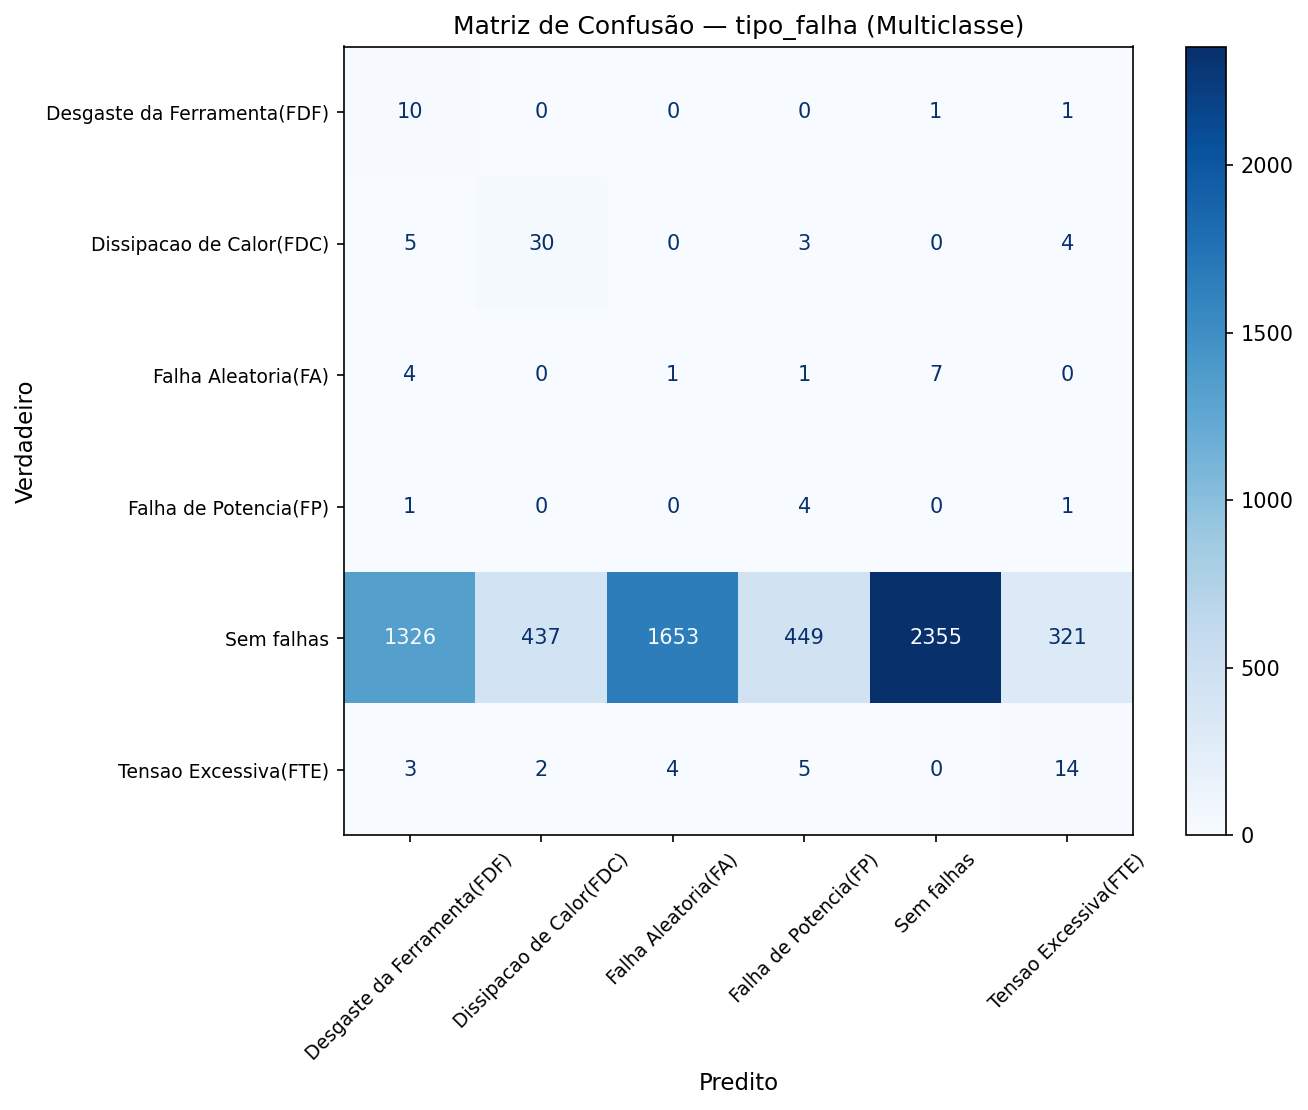

In [ ]:
# Pipeline base (pré-processamento + modelo)
lr_pipe = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",              
        class_weight="balanced",
        max_iter=2000,
        random_state=RANDOM_SEED
    ))
])

# Cross-Validation (5 folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# hiperparâmetros para testar 
param_grid = {
    "model__C": [0.01, 0.1, 1.0, 3.0],
    "model__penalty": ["l2"]
}

# === Grid Search no PIPELINE (sem vazamento) ===
gs = GridSearchCV(
    estimator=lr_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="recall_macro",        
    n_jobs=-1,
    refit=True,                    
    verbose=0
)

# Treino + seleção de hiperparâmetros
gs.fit(X_train, y_train)

# Melhor pipeline já refitado
lr_pipe_tuned = gs.best_estimator_

# Predições
y_pred  = lr_pipe_tuned.predict(X_test)
y_proba = lr_pipe_tuned.predict_proba(X_test)       
classes_model = lr_pipe_tuned.named_steps["model"].classes_
proba_df = pd.DataFrame(y_proba, columns=classes_model, index=X_test.index)

print("Melhores hiperparâmetros:", gs.best_params_)
print("\nProbabilidades por classe:")
print(proba_df.head())

# Avaliação (macro = mesma importância para cada classe)
print("\nLogistic Regression Tuned (Multiclasse)")

# Relatório detalhado (por classe)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4, zero_division=0))

# Matriz de Confusão (labels legíveis)
labels_full = classes_all if classes_all is not None else classes_model
cm = confusion_matrix(y_test, y_pred, labels=labels_full)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_full)

fig, ax = plt.subplots(figsize=(9.5, 7.5), dpi=150)
disp.plot(cmap='Blues', values_format='d', colorbar=True, ax=ax)
ax.set_title("Matriz de Confusão — tipo_falha (Multiclasse)", fontsize=12)
ax.set_xlabel("Predito", fontsize=11)
ax.set_ylabel("Verdadeiro", fontsize=11)
ax.tick_params(axis='x', labelrotation=45, labelsize=9)
ax.tick_params(axis='y', labelsize=9)
plt.tight_layout()
plt.show()

## 2.3) Random Forest com hiperparâmetros

Melhores hiperparâmetros: {'model__n_estimators': 150, 'model__min_samples_leaf': 4, 'model__max_features': None, 'model__max_depth': 8}
Score CV (média, recall_macro): 0.47502057600728415

Ensemble Models: Random Forest (multiclasse) — tuned

=== Classification Report ===
                             precision    recall  f1-score   support

Desgaste da Ferramenta(FDF)     0.0086    0.0833    0.0156        12
   Dissipacao de Calor(FDC)     0.2672    0.7381    0.3924        42
        Falha Aleatoria(FA)     0.0063    0.1538    0.0122        13
      Falha de Potencia(FP)     0.2500    0.3333    0.2857         6
                 Sem falhas     0.9930    0.9067    0.9479      6541
      Tensao Excessiva(FTE)     0.1228    0.5000    0.1972        28

                   accuracy                         0.9005      6642
                  macro avg     0.2747    0.4526    0.3085      6642
               weighted avg     0.9803    0.9005    0.9371      6642



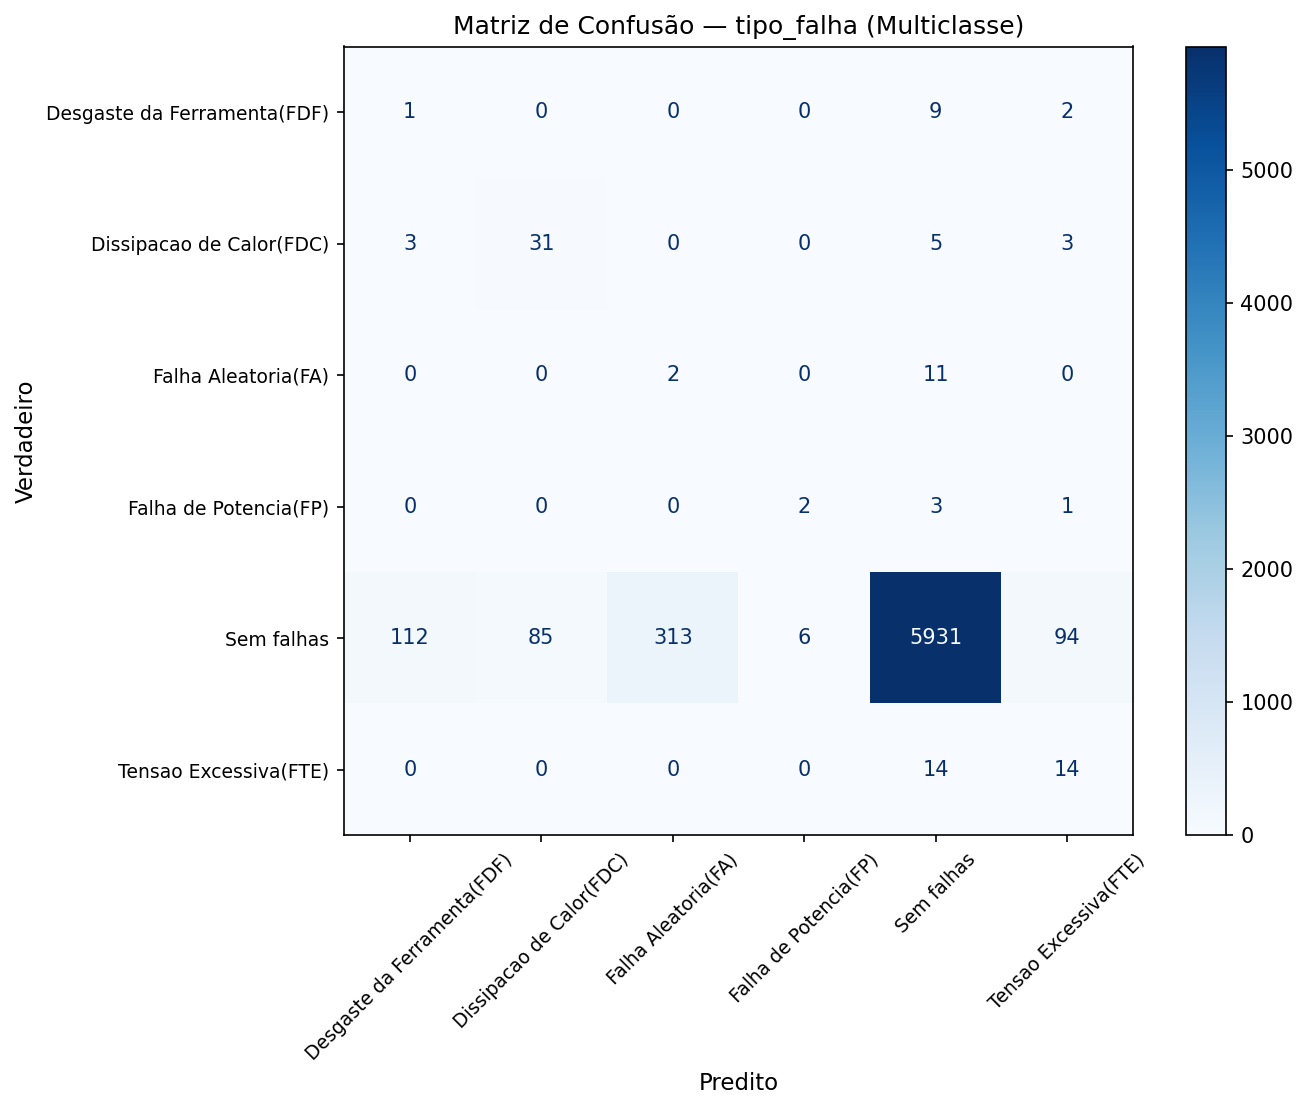

In [18]:
# === CV ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# === Pipeline base (pré + modelo) ===
rf_pipe = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", RandomForestClassifier(
        random_state=RANDOM_SEED,
        class_weight="balanced", 
        n_jobs=-1
    ))
])

# === Espaço de busca (prefixo model__) ===
rf_param_dist = {
    "model__n_estimators":   [150, 250, 350, 500],
    "model__max_depth":      [None, 8, 12, 16, 22],
    "model__min_samples_leaf":[1, 2, 4],
    "model__max_features":   ["sqrt", None]
}

# === RandomizedSearchCV no PIPELINE ===
rf_search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_param_dist,
    n_iter=20,
    cv=cv,
    scoring="recall_macro",    # métrica alvo em multiclasse
    n_jobs=-1,
    random_state=RANDOM_SEED,
    refit=True,
    verbose=0
)

# Treino + seleção
rf_search.fit(X_train, y_train)

print("Melhores hiperparâmetros:", rf_search.best_params_)
print("Score CV (média, recall_macro):", rf_search.best_score_)

# Melhor pipeline já refitado
best_pipe = rf_search.best_estimator_

# Predições
y_pred  = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)           # (n_amostras x n_classes)
classes_model = best_pipe.named_steps["model"].classes_

# Avaliação
print("\nEnsemble Models: Random Forest (multiclasse) — tuned")
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4, zero_division=0))

# Matriz de Confusão com rótulos legíveis
labels = classes_all if classes_all is not None else classes_model
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(9.5, 7.5), dpi=150)
disp.plot(cmap='Blues', values_format='d', colorbar=True, ax=ax)
ax.set_title("Matriz de Confusão — tipo_falha (Multiclasse)", fontsize=12)
ax.set_xlabel("Predito", fontsize=11)
ax.set_ylabel("Verdadeiro", fontsize=11)
ax.tick_params(axis='x', labelrotation=45, labelsize=9)
ax.tick_params(axis='y', labelsize=9)
plt.tight_layout()
plt.show()

### XGBoost

Melhores hiperparâmetros: {'model__subsample': 0.7, 'model__reg_lambda': 3.0, 'model__n_estimators': 200, 'model__min_child_weight': 5, 'model__max_depth': 6, 'model__learning_rate': 0.03, 'model__colsample_bytree': 0.9}

Ensemble Models: XGBoost (multiclasse) — tuned

=== Classification Report ===
                             precision    recall  f1-score   support

Desgaste da Ferramenta(FDF)     0.0171    0.1667    0.0310        12
   Dissipacao de Calor(FDC)     0.2011    0.8571    0.3258        42
        Falha Aleatoria(FA)     0.0000    0.0000    0.0000        13
      Falha de Potencia(FP)     0.1250    0.3333    0.1818         6
                 Sem falhas     0.9949    0.9176    0.9547      6541
      Tensao Excessiva(FTE)     0.0958    0.5714    0.1641        28

                   accuracy                         0.9121      6642
                  macro avg     0.2390    0.4744    0.2762      6642
               weighted avg     0.9816    0.9121    0.9431      6642



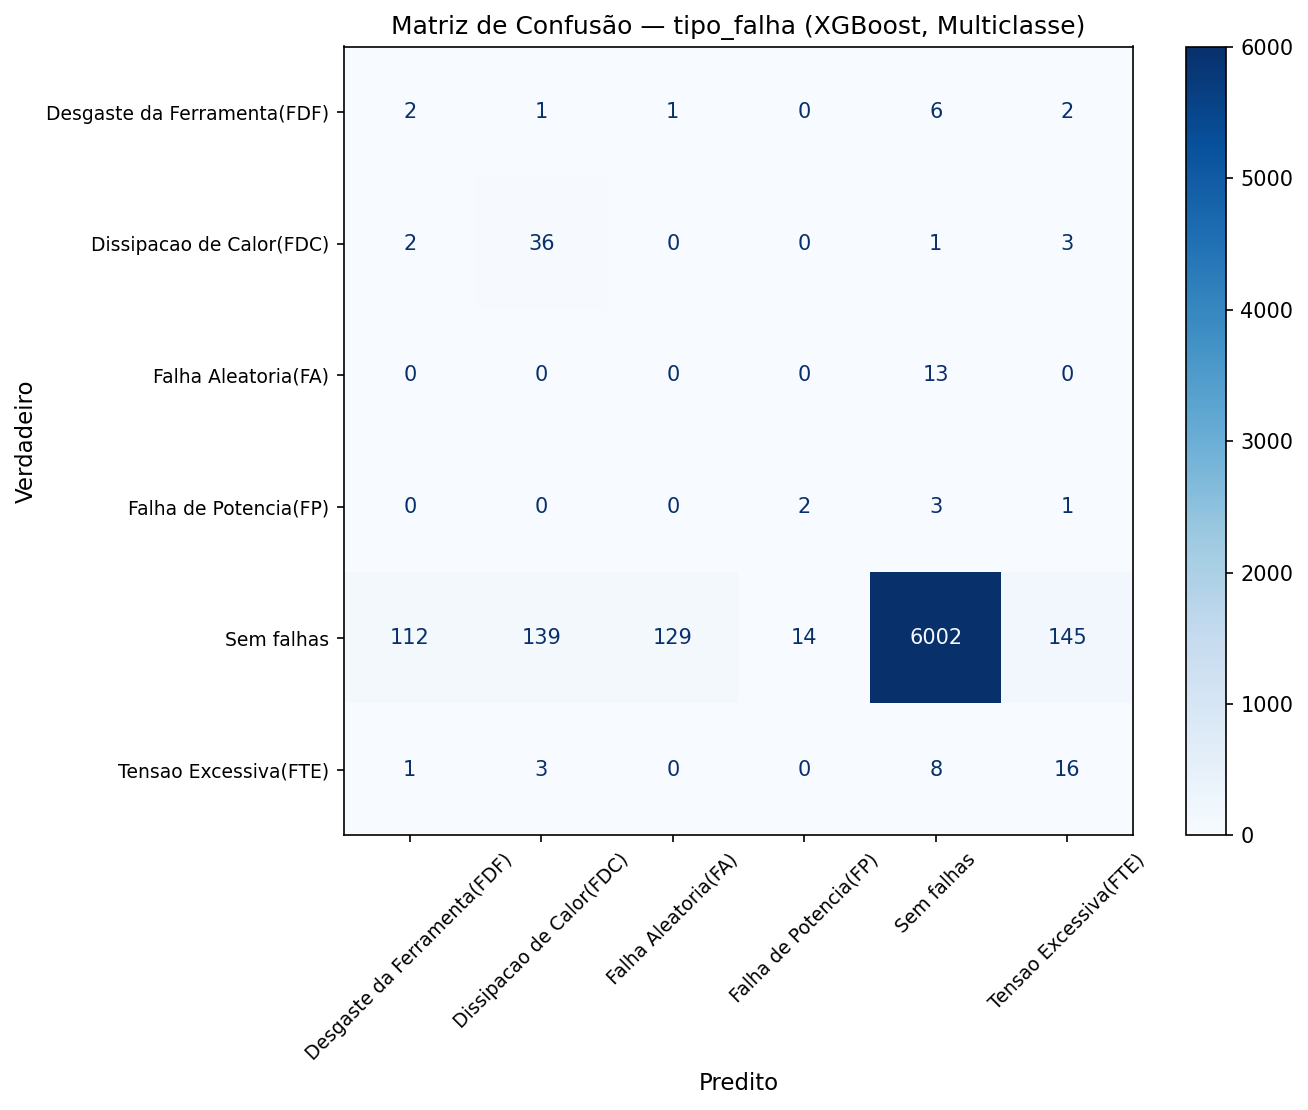

In [19]:
# === Label encoding do alvo (obrigatório p/ XGBoost multiclasse) ===
le = LabelEncoder()
if classes_all is not None:
    # garante mapeamento consistente com a etapa de prep
    le.classes_ = np.array(classes_all)
else:
    le.fit(y_train)

y_train_enc = le.transform(y_train)   # inteiros 0..K-1
y_test_enc  = le.transform(y_test)
n_classes   = len(le.classes_)

# === CV ===
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

# === Pesos balanceados por classe (em cima do y codificado) ===
sample_weight = compute_sample_weight(class_weight="balanced", y=y_train_enc)

# === Pipeline (pré + modelo) ===
xgb_pipe = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", XGBClassifier(
        objective="multi:softprob",   # probas por classe
        num_class=n_classes,
        eval_metric="mlogloss",       # ou "merror"
        tree_method="hist",
        booster="gbtree",
        random_state=RANDOM_SEED,
        n_jobs=-1,
    ))
])

# === Espaço de busca (prefixo model__) ===
xgb_dist = {
    "model__n_estimators":     [200, 400, 600],
    "model__max_depth":        [4, 6, 8, 10],
    "model__learning_rate":    [0.03, 0.1, 0.2],
    "model__subsample":        [0.7, 0.9, 1.0],
    "model__colsample_bytree": [0.7, 0.9, 1.0],
    "model__reg_lambda":       [0.0, 1.0, 3.0, 5.0],
    "model__min_child_weight": [1, 3, 5],
}

# === RandomizedSearchCV no PIPELINE (sem vazamento) ===
xgb_search = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=xgb_dist,
    n_iter=20,
    cv=cv,
    scoring="recall_macro",      #métrica primária
    n_jobs=-1,
    random_state=RANDOM_SEED,
    refit=True,
    verbose=0
)

# Treino + busca (passa sample_weight ao passo 'model' do pipeline)
xgb_search.fit(X_train, y_train_enc, **{"model__sample_weight": sample_weight})

print("Melhores hiperparâmetros:", xgb_search.best_params_)

# Melhor pipeline já refitado
best_pipe = xgb_search.best_estimator_

# Predições (encodadas) e probabilidades
y_pred_enc = best_pipe.predict(X_test)
y_proba    = best_pipe.predict_proba(X_test)   # (n_amostras x n_classes)

# Decodifica para rótulos originais (strings) para relatórios/plots
y_pred = le.inverse_transform(y_pred_enc)

# Avaliação
print("\nEnsemble Models: XGBoost (multiclasse) — tuned")
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4, zero_division=0))

# Matriz de Confusão com rótulos legíveis
labels = list(le.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(9.5, 7.5), dpi=150)
disp.plot(cmap='Blues', values_format='d', colorbar=True, ax=ax)
ax.set_title("Matriz de Confusão — tipo_falha (XGBoost, Multiclasse)", fontsize=12)
ax.set_xlabel("Predito", fontsize=11)
ax.set_ylabel("Verdadeiro", fontsize=11)
ax.tick_params(axis='x', labelrotation=45, labelsize=9)
ax.tick_params(axis='y', labelsize=9)
plt.tight_layout()
plt.show()


### Avaliação dos Modelos

**Conclusões:**
- GBoost Tuned → Modelo recomendado para implantação em manutenção preditiva:
    - Maior recall (detecta mais falhas reais).
    - Excelente F1-Score (bom equilíbrio entre detectar e evitar alarmes falsos).
    - Probabilidades calibradas, úteis para priorizar severidade das falhas.

- Random Forest Tuned → Modelo secundário/backup, boa interpretabilidade para explicar decisões.
- Logistic Regression (Tuned e Base) → Úteis como referência, mas insuficientes para aplicação prática no cenário industrial.

| Modelo                         |  Accuracy | Precision (macro) | Recall (macro) | F1 (macro) |
| ------------------------------ | --------: | ----------------: | -------------: | ---------: |
| **XGBoost (tuned)**            | **0.982** |         **0.412** |          0.411 |  **0.407** |
| **Random Forest (tuned)**      |     0.901 |             0.275 |      **0.453** |      0.309 |
| Logistic Regression (baseline) |     0.363 |             0.186 |          0.525 |      0.126 |
| Logistic Regression (tuned)    |     0.306 |             0.179 |          0.532 |      0.102 |

